# Optimizing Specular Lighting with Spherical Gaussian

In contrast to `diffuse_lighting.ipynb`, this tutorial describes how to optimize multiple light probes while also accounting for **specular lighting effects**. The light is modeled using Spherical Gaussians, and we will optimize <fill in parameters here>.

For more details on the logic and usage of the approaches, we suggest to read the [MJP Blog post on Diffuse Lighting From an SG Light Source](https://therealmjp.github.io/posts/sg-series-part-3-diffuse-lighting-from-an-sg-light-source/)

In [1]:
!pip install matplotlib
import kaolin as kal
import torch
import math
from matplotlib import pyplot as plt

def generate_pinhole_rays_dir(camera, device='cuda'):
    """Ray direction generation function for pinhole cameras.

    This function assumes that the principal point (the pinhole location) is specified by a 
    displacement (camera.x0, camera.y0) in pixel coordinates from the center of the image. 
    The Kaolin camera class does not enforce a coordinate space for how the principal point is specified,
    so users will need to make sure that the correct principal point conventions are followed for 
    the cameras passed into this function.

    Args:
        height (int): The resolution height.
        width (int): The resolution width.
        camera (kaolin.render.camera.Camera): The camera instance, should be of batch == 1.
    Returns:
        (torch.Tensor): the rays directions, of shape (height, width, 3)
    """
    # Generate centered grid
    pixel_y, pixel_x = torch.meshgrid(
        torch.arange(camera.height, device=device),
        torch.arange(camera.width, device=device)
    )
    pixel_x = pixel_x + 0.5  # scale and add bias to pixel center
    pixel_y = pixel_y + 0.5  # scale and add bias to pixel center

    # Account for principal point (offsets from the center)
    pixel_x = pixel_x - camera.x0
    pixel_y = pixel_y + camera.y0

    # pixel values are now in range [-1, 1], both tensors are of shape res_y x res_x
    # Convert to NDC
    pixel_x = 2 * (pixel_x / camera.width) - 1.0
    pixel_y = 2 * (pixel_y / camera.height) - 1.0

    ray_dir = torch.stack((pixel_x * camera.tan_half_fov(kal.render.camera.intrinsics.CameraFOV.HORIZONTAL),
                           -pixel_y * camera.tan_half_fov(kal.render.camera.intrinsics.CameraFOV.VERTICAL),
                           -torch.ones_like(pixel_x)), dim=-1)

    ray_dir = ray_dir.reshape(-1, 3)    # Flatten grid rays to 1D array
    ray_orig = torch.zeros_like(ray_dir)

    # Transform from camera to world coordinates
    ray_orig, ray_dir = camera.extrinsics.inv_transform_rays(ray_orig, ray_dir)
    ray_dir /= torch.linalg.norm(ray_dir, dim=-1, keepdim=True)

    return ray_dir[0].reshape(camera.height, camera.width, 3)

def disp_imgs(imgs, title=None):
    """scatter images plotting"""
    nb_scenes, nb_views, _, _, _ = imgs.shape
    f, axes = plt.subplots(nb_scenes, nb_views, figsize=(1.95 * nb_views, 2. * nb_scenes))
    f.suptitle(title, fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in range(nb_views):
        for j in range(nb_scenes):
            axes[j, i].imshow(imgs[j, i].cpu().detach())
            axes[j, i].set_xticks([])
            axes[j, i].set_yticks([])

## Loading 3D model

Here we are loading a simple sphere mesh with materials, which are preprocessed for rendering.

In [2]:
mesh = kal.io.obj.import_mesh('../samples/colored_sphere.obj', with_materials=True, with_normals=True)

# Batch, move to GPU and center and normalize vertices in the range [-0.5, 0.5]
mesh = mesh.to_batched().cuda()
mesh.vertices = kal.ops.pointcloud.center_points(mesh.vertices, normalize=True)
print(mesh)

# Take diffuse texture map component from materials
diffuse_texture = mesh.materials[0][0]['map_Kd'].cuda().float().permute(2, 0, 1).unsqueeze(0) / 255.
# Take single diffuse texture
specular_texture = mesh.materials[0][0]['Ks'].cuda().float().reshape(1, 1, 3)

SurfaceMesh object with batching strategy FIXED
            vertices: [1, 642, 3] (torch.float32)[cuda:0]  
             normals: [1, 642, 3] (torch.float32)[cuda:0]  
                 uvs: [1, 671, 2] (torch.float32)[cuda:0]  
               faces: [1280, 3] (torch.int64)[cuda:0]  
        face_uvs_idx: [1, 1280, 3] (torch.int64)[cuda:0]  
    face_normals_idx: [1, 1280, 3] (torch.int64)[cuda:0]  
material_assignments: [1, 1280] (torch.int16)[cuda:0]  
           materials: [
                      0: list of length 1
                      ]
      vertex_normals: if possible, computed on access from: (faces, face_normals)
        face_normals: if possible, computed on access from: (normals, face_normals_idx) or (vertices, faces)
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
       face_vertices: if possible, computed on access from: (faces, vertices)


## Camera

We instantiate a camera object and transform vertices into the camera coordinate frame to support rasterization.

In [3]:
cam_pos = torch.tensor([
    [0., 0., 1.],
    [0., -0.3, 0.9],
    [0., -1., 1.],
    [0., -0.999, 0.111],
    [0., 0.999, 0.111],
    [0.5, 0., 0.5]
], device='cuda')
nb_views = cam_pos.shape[0]
cam_pos = cam_pos / cam_pos.norm(dim=-1, keepdim=True)
cams = kal.render.camera.Camera.from_args(
    eye=cam_pos,
    at=torch.tensor([[0., 0., 0.]], device='cuda').repeat(nb_views, 1),
    up=torch.tensor([[0., 1., 0.]], device='cuda').repeat(nb_views, 1),
    fov=70. * 2. * math.pi / 360,
    width=256, height=256, device='cuda'
)
vertices_camera = cams.extrinsics.transform(mesh.vertices)
vertices_ndc = cams.intrinsics.transform(vertices_camera)
face_vertices_camera = kal.ops.mesh.index_vertices_by_faces(vertices_camera, mesh.faces)
face_vertices_image = kal.ops.mesh.index_vertices_by_faces(vertices_ndc[..., :2], mesh.faces)
face_vertices_z = face_vertices_camera[..., -1]

# Compute the rays
rays_d = []
for cam in cams:
    rays_d.append(generate_pinhole_rays_dir(cam))
# Rays must be toward the camera
rays_d = -torch.stack(rays_d, dim=0)

/home/mshugrina/anaconda3/envs/kaolin-dev/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Rasterize albedo and world normals

The first step toward rendering with lighting is to render the albedo (color) and normals in world coordinate system. In addition, we also render the specular albedo. 

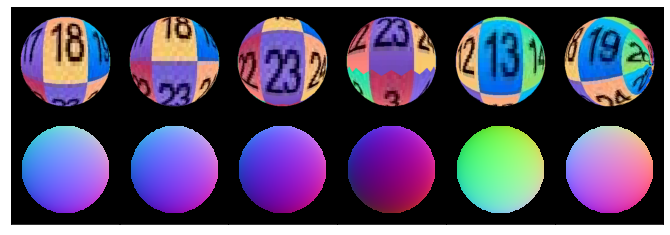

In [4]:
imsize = 256
im_features, face_idx = kal.render.mesh.rasterize(
    imsize, imsize, face_vertices_camera[..., -1], face_vertices_image,
    [mesh.face_uvs.repeat(nb_views, 1, 1, 1), mesh.face_normals.repeat(nb_views, 1, 1, 1)]
)
hard_mask = face_idx != -1
hard_mask = hard_mask
uv_map = im_features[0]
im_world_normal = im_features[1] / torch.sqrt(torch.sum(im_features[1] * im_features[1], dim=-1, keepdim=True))
albedo = kal.render.mesh.texture_mapping(uv_map, diffuse_texture.repeat(nb_views, 1, 1, 1))
albedo = torch.clamp(albedo * hard_mask.unsqueeze(-1), min=0., max=1.)
spec_albedo = hard_mask.unsqueeze(-1) * specular_texture # Here is because specular texture is a single pixel
disp_imgs(torch.stack([albedo, ((im_world_normal + 1.) / 2.)], dim=0))

## Render synthetic ground truth

For the purpose of this demonstration, let us create synthetic ground truth renders we can use to drive optimization of the lighting parameters. 

The scene is composed of two spherical gaussian defined by their direction (as a unit vector), amplitude and sharpness.

We render and add both diffusion and specular lighting effects using respectively [kaolin.render.sg_diffuse_fitted](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.html#kaolin.render.sg_diffuse_fitted) and [kaolin.render.sg_warp_specular_term](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.html#kaolin.render.sg_warp_specular_term).

Real photographs or renderings of a complex scene would be used in a realistic scenario.

<ipython-input-5-c18d08d6ccbc>:16: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at  ../torch/csrc/jit/codegen/cuda/manager.cpp:329.)
  diffuse_effect = kal.render.lighting.sg_diffuse_fitted(


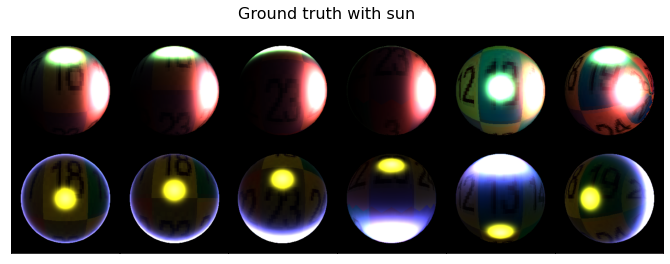

In [5]:
gt_azimuth = torch.tensor([[0., math.pi / 2.], [0., 0.]], device='cuda')
gt_elevation = torch.tensor([[0., 0.], [-math.pi / 2., math.pi / 2.]], device='cuda')
nb_scenes = gt_azimuth.shape[0]
gt_amplitude = torch.tensor([[[5., 2., 2.], [5., 10., 5.]], [[3., 3., 7.], [8., 8., 1.]]], device='cuda')
gt_sharpness = torch.tensor([[6., 20.], [5., 40.]], device='cuda')
roughness = torch.full((nb_views, imsize, imsize), 0.1, device='cuda')
def render(azimuth, elevation, amplitude, sharpness, im_world_normal,
           albedo, spec_albedo, roughness):
    """Render diffuse and specular components.
    
    Use spherical gaussian fitted approximation for the diffuse component"""
    directions = torch.stack(kal.ops.coords.spherical2cartesian(azimuth, elevation), dim=-1)
    img = torch.zeros((directions.shape[0], *im_world_normal.shape), device='cuda')
    for j in range(directions.shape[0]):
        # Render diffuse component
        diffuse_effect = kal.render.lighting.sg_diffuse_fitted(
            amplitude[j],
            directions[j],
            sharpness[j],
            im_world_normal[hard_mask],
            albedo[hard_mask]
        )
        img[j, hard_mask] += diffuse_effect
        # Render specular component
        specular_effect = kal.render.lighting.sg_warp_specular_term(
            amplitude[j],
            directions[j],
            sharpness[j],
            im_world_normal[hard_mask],
            roughness[hard_mask],
            rays_d[hard_mask],
            spec_albedo[hard_mask]
        )
        img[j, hard_mask] += specular_effect
    return img

gt_img = render(gt_azimuth, gt_elevation, gt_amplitude, gt_sharpness, im_world_normal,
                albedo, spec_albedo, roughness)
# Compute irradiance
disp_imgs(torch.clamp(gt_img, 0., 1.), "Ground truth with sun")

## Optimize Spherical Gaussians parameters

Using the same rendering functions and re-initialized the spherical gaussians we can optimize the position, amplitude and sharpness of the spherical gaussians using mean squared error on the rendered image as a loss function.

Final values
azimuth: tensor([[ 1.5762e+00, -1.0824e-03],
        [-1.6623e+00, -1.6776e+00]], device='cuda:0', requires_grad=True)
elevation: tensor([[ 1.2093e-03,  2.9463e-06],
        [ 1.5684e+00, -1.5728e+00]], device='cuda:0', requires_grad=True)
amplitude: tensor([[[ 4.9118,  9.8171,  4.9072],
         [ 5.0061,  1.9998,  2.0014]],

        [[ 5.2865,  5.2948, -1.4437],
         [ 2.9852,  2.9860,  6.9958]]], device='cuda:0', requires_grad=True)
sharpness: tensor([[19.4408,  6.0159],
        [22.7100,  4.9811]], device='cuda:0', requires_grad=True)


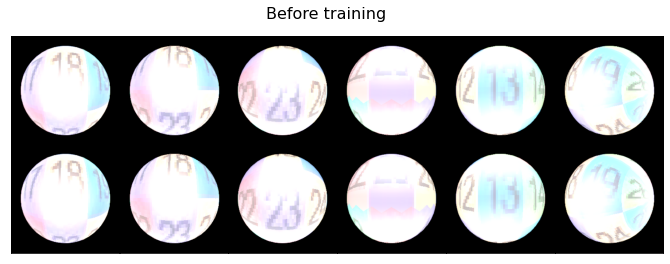

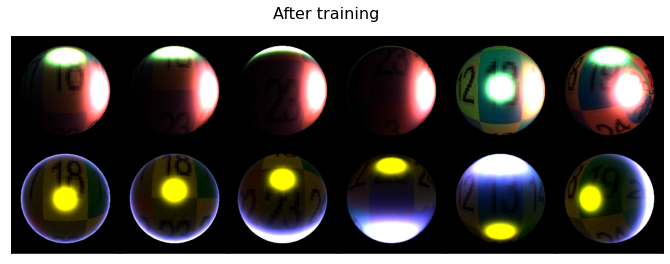

In [6]:
azimuth = torch.zeros((nb_scenes, 2), device='cuda', requires_grad=True)
elevation = torch.tensor([[math.pi / 2., -math.pi / 2.]], device='cuda').repeat(nb_scenes, 1)
elevation.requires_grad = True
amplitude = torch.ones((nb_scenes, 2, 3), device='cuda', requires_grad=True)
sharpness = torch.ones((nb_scenes, 2), device='cuda', requires_grad=True)

with torch.no_grad():
    sg_img = torch.clamp(render(
        azimuth, elevation, amplitude, sharpness, im_world_normal,
        albedo, spec_albedo, roughness
    ), 0., 1)

    disp_imgs(sg_img, "Before training")

optim = torch.optim.Adam([azimuth, elevation, amplitude, sharpness], lr=0.3)

# Optimization loop
for i in range(500):
    optim.zero_grad()
    sg_img = render(
        azimuth, elevation, amplitude, sharpness, im_world_normal,
        albedo, spec_albedo, roughness
    )
    loss = torch.nn.functional.mse_loss(sg_img, gt_img)
    loss.backward()
    optim.step()

# Post-training evaluation
with torch.no_grad():
    sg_img = torch.clamp(render(
        azimuth, elevation, amplitude, sharpness, im_world_normal,
        albedo, spec_albedo, roughness
    ), 0., 1)

    disp_imgs(sg_img, "After training")

print("Final values")
print("azimuth:", azimuth)
print("elevation:", elevation)
print("amplitude:", amplitude)
print("sharpness:", sharpness)